In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

total_files = 0
total_direct = 0
try:
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            total_files +=1

        total_direct +=1
    print("Total number of directories: "+ str(total_direct))
    print("Total number of files: "+str(total_files))
except:
    print("An error occured walking through the OS Directories")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Total number of directories: 6
Total number of files: 815


In [4]:
#Required libraries

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras import Model
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from skimage.metrics import structural_similarity as ssim

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [5]:
"""Structure of the training model:
--- Where to find all the data for training and testing
X_train_data_path = "/input_file/training_data/images"
X_test_data_path = "/input_file/test_data/images"

--- Storing the data for training from the above paths
x_train = []

--- Iterate through the folder and pull out the files that end with ".jpeg" and add them to the training list.
for filename in os.listdir(x_train_path):
    if filename.endswith(".jpeg"):
        img = image.load_img(x_train_path+filename, target_size=(128, 128))
        x_train.append(image.img_to_array(img))
x_train = np.array(x_train)

--- Storing the data for testing from the above paths
x_test = []

---Iterate through the folder and pull out the files that end with ".jpeg" and add them to the test list.
for filename in os.listdir(x_test_path):
    if filename.endswith(".jpeg"):
        img = image.load_img(x_test_path+filename, target_size=(128, 128))
        x_test.append(image.img_to_array(img))
x_test = np.array(x_test)

"""





'Structure of the training model:\n--- Where to find all the data for training and testing\nX_train_data_path = "/input_file/training_data/images"\nX_test_data_path = "/input_file/test_data/images"\n\n--- Storing the data for training from the above paths\nx_train = []\n\n--- Iterate through the folder and pull out the files that end with ".jpeg" and add them to the training list.\nfor filename in os.listdir(x_train_path):\n    if filename.endswith(".jpeg"):\n        img = image.load_img(x_train_path+filename, target_size=(128, 128))\n        x_train.append(image.img_to_array(img))\nx_train = np.array(x_train)\n\n--- Storing the data for testing from the above paths\nx_test = []\n\n---Iterate through the folder and pull out the files that end with ".jpeg" and add them to the test list.\nfor filename in os.listdir(x_test_path):\n    if filename.endswith(".jpeg"):\n        img = image.load_img(x_test_path+filename, target_size=(128, 128))\n        x_test.append(image.img_to_array(img))\n

In [6]:
#Add the path for the images
X_train_data_path = "/kaggle/input/flower-color-images/flowers/flowers/"
X_test_data_path = "/kaggle/input/flower-color-images/flower_images/flower_images/"


#Storing the data for training from the above paths
x_train = []

#Add each file to the training set that matches the the end extension
for filename in os.listdir(X_train_data_path):
    if filename.endswith(".png"):
        img = image.load_img(X_train_data_path+filename, target_size=(224, 224))
        x_train.append(image.img_to_array(img))
appendx_train = np.array(x_train)

#Storing the data for testing from the above paths
x_test = []

#Add each file to the testing set that matches the the end extension
for filename in os.listdir(X_test_data_path):
    if filename.endswith(".png"):
        img = image.load_img(X_test_data_path+filename, target_size=(224, 224))
        x_test.append(image.img_to_array(img))
x_test = np.array(x_test)

In [7]:
#Convert the arrays to numpy arrays
x_train = np.array(x_train)
x_test = np.array(x_test)

#Test the shape of the data
print(x_train.shape)
print(x_test.shape)

(603, 224, 224, 3)
(210, 224, 224, 3)


In [8]:
#Reset the tensorflow graph so the resulting code that follows is not impacted
tf.compat.v1.reset_default_graph()

#Setting the training sizes for the convolutions
input_img = Input(shape=(224, 224, 3))  
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)  
x = MaxPooling2D((2, 2))(x)  
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)  

#Compress the image
encoded = MaxPooling2D((2, 2))(x)

#Transpose the convolutions while encoded
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(encoded)  
x = UpSampling2D((2, 2))(x)  
x = Conv2DTranspose(32, (3, 3), activation='relu',padding='same')(x) 
x = UpSampling2D((2, 2))(x)  

decoded = Conv2D(3, (3, 3), padding='same')(x)  

autoencoder = Model(input_img, decoded)  

In [9]:
#Instantiate the model and train using: Adam optimizer, MSE for loss function, and test based on accuracy
autoencoder.compile(optimizer='adam', loss='mse' , metrics=['accuracy']) 

In [10]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 16)      4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 16)       0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 56, 56, 16)       2320  

In [11]:
#Fit the model with the training data, for 13 epochs and then validate using the assigned test data

autoencoder.fit(x_train, x_train,
                epochs=13,
                batch_size=2,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/13
302/302 [==============================] - 85s 275ms/step - loss: 831.3456 - accuracy: 0.6987 - val_loss: 288.2627 - val_accuracy: 0.7950
Epoch 2/13
302/302 [==============================] - 83s 274ms/step - loss: 285.5500 - accuracy: 0.8194 - val_loss: 238.9576 - val_accuracy: 0.8228
Epoch 3/13
302/302 [==============================] - 83s 273ms/step - loss: 239.4807 - accuracy: 0.8308 - val_loss: 195.2706 - val_accuracy: 0.8350
Epoch 4/13
302/302 [==============================] - 83s 273ms/step - loss: 216.1244 - accuracy: 0.8349 - val_loss: 276.5686 - val_accuracy: 0.7542
Epoch 5/13
302/302 [==============================] - 82s 273ms/step - loss: 211.4576 - accuracy: 0.8318 - val_loss: 159.5541 - val_accuracy: 0.8564
Epoch 6/13
302/302 [==============================] - 82s 273ms/step - loss: 187.6742 - accuracy: 0.8445 - val_loss: 176.8815 - val_accuracy: 0.8352
Epoch 7/13
302/302 [==============================] - 82s 271ms/step - loss: 182.9448 - accuracy: 0.8400 -

In [12]:
#Define a function to display the images in row
def show_images(X, n=3, title=""):
    plt.figure(figsize=(20, 8))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        plt.imshow(image.array_to_img(X[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle(title, fontsize = 20)

In [13]:
predicted_images = autoencoder.predict(x_test)

7/7 [==============================] - 6s 846ms/step


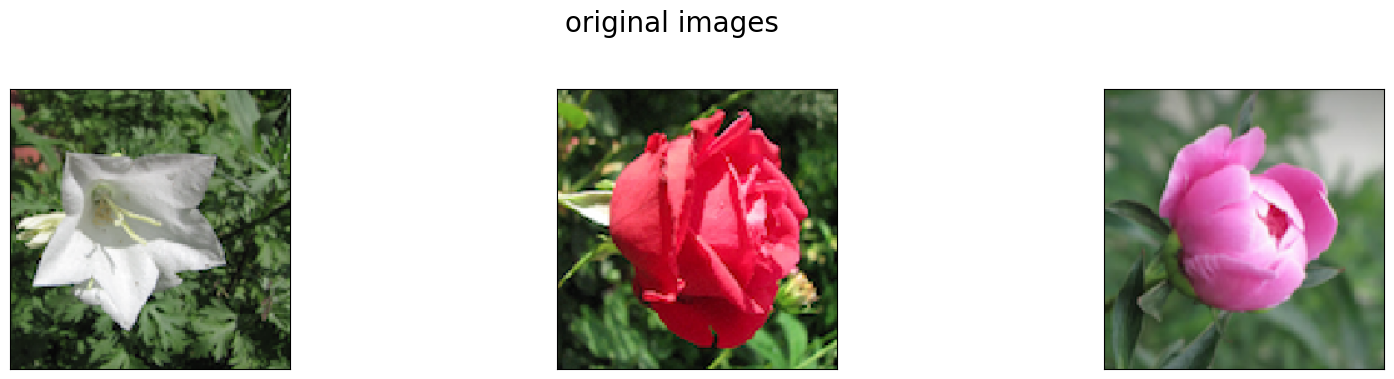

In [14]:
show_images(x_test, title="original images")

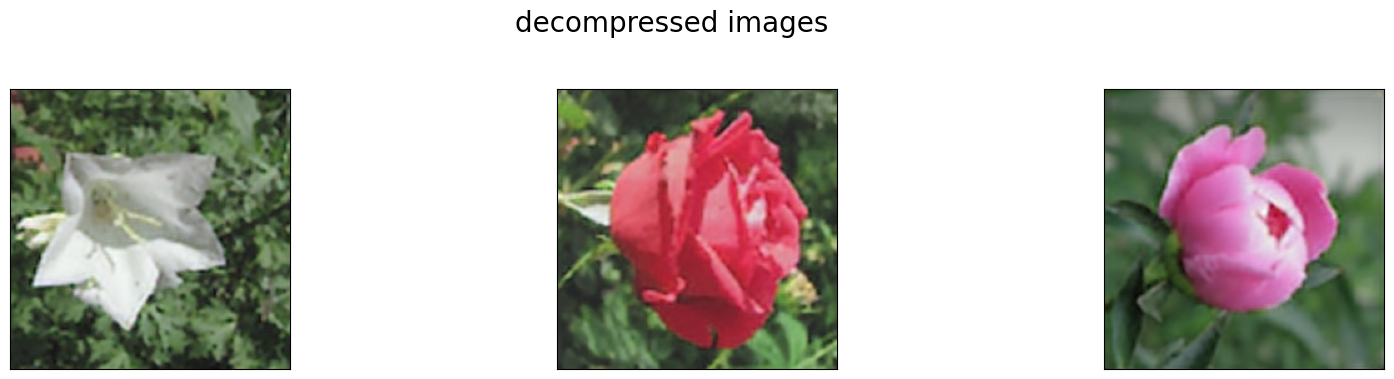

In [15]:
show_images(predicted_images, title="decompressed images")

In [19]:
predicted_images[0].shape

(224, 224, 3)